# Final Project Demo
This notebook is only for demonstration purpose, meaning it is not used to produce the actual results in the report.
As a demo, we run both quantum and classical models for once with the hyperparameter settings which produces the loss of plasticity.
Note that the URL for the EMNIST in torchvision.dataset is broken, so need to manually download the data from https://www.nist.gov/itl/products-and-services/emnist-dataset, or from https://github.com/WINUprj/lop-qcl/tree/develop/dataset/EMNIST/raw.
Since this notebook was originally edited on the author's local environment, we highly recommend cloning the source repo, creating a virtual environment, and then running the jupyter lab/notebook to execute this notebook.

The source repo can be found here: https://github.com/WINUprj/lop-qcl

In [26]:
import os
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.optim import SGD, Adam, RMSprop
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import v2 as T
from tqdm import tqdm
import pennylane as qml

In [5]:
### Utiltiies
def seed_everything(seed: int):
    """Set seed of the entire environment."""
    # Standard Python3 library-related
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)

    # NumPy-related
    np.random.seed(seed)

    # Torch-related
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def moving_avg(data: np.ndarray, n: int):
    """Compute the moving average of the given array with given window size."""
    cs = np.cumsum(data)
    diff = cs[n:] - cs[:-n]
    return diff / n


def accuracy(pred, label):
    """Compute the accuracy between predicted probability and the target labels."""
    return np.sum(pred.argmax(axis=1) == label) / pred.shape[0]

In [6]:
### Dataset
class CustomLetterEMNIST(Dataset):
    def __init__(
        self,
        data_root_dir,
        train,
        transforms,
        label_subset = None,
    ):
        original_emnist = torchvision.datasets.EMNIST(
            data_root_dir,
            split="letters",
            train=train,
        )

        self.transforms = transforms

        if label_subset is None:
            self.images = original_emnist.data
            self.targets = original_emnist.targets
        else:
            # Collect subset index of the data
            original_targets = original_emnist.targets
            subset_idx = (original_targets == label_subset[0])
            for l in label_subset[1:]:
                subset_idx |= (original_targets == l)
                
            subset_dict = {label_subset[i]: i for i in range(len(label_subset))}

            self.images = original_emnist.data[subset_idx, :]
            self.targets = original_targets[subset_idx]

            # Only take half of the targets
            half_idx = torch.randperm(self.targets.size()[0] // 2)
            self.images = self.images[half_idx]
            self.targets = self.targets[half_idx]

            # Convert the value of label indices to allow training
            fn = lambda x: subset_dict[x]
            self.targets = self.targets.apply_(fn)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        images = self.images[idx, :]
        if images.ndim <= 2:
            images = images.unsqueeze(0)
        if self.transforms is not None:
            images = self.transforms(images)
            
        labels = self.targets[idx]
        
        return images, labels
        

class LabelPermutedEMNIST:
    """
    Label permuted EMNIST task.
    """
    def __init__(
        self,
        dataset_root,
        in_dim=(16, 16),
        out_dim=26,
        train=True,
        shuffle=True,
        update_freq=1000,
        batch_size=1,
        img_transform=None,
        label_subset=None,
    ):
        self.dataset_root = dataset_root
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.train = train
        self.shuffle = shuffle
        self.update_freq = update_freq
        self.batch_size = batch_size
        self.img_transform=img_transform
        self.label_subset=label_subset

        self.step = 0

    def __iter__(self):
        return self

    def __next__(self):
        # Update label permutation after one task ends
        if self.step % self.update_freq == 0:
            self.permute()
        self.step += 1

        try:
            return next(self.data_loader)
        except StopIteration:
            # Regenerate the data loader if current loader exhaust the data
            self.data_loader = self._get_data_loader()
            return next(self.data_loader)
    
    def _get_data_loader(self):
        return iter(DataLoader(
            self.dataset,
            self.batch_size,
            shuffle=self.shuffle
        ))
    
    def _get_dataset(self):
        self.dataset = CustomLetterEMNIST(self.dataset_root,
                                          self.train,
                                          self.img_transform,
                                          self.label_subset)

    def _apply_permutation(self, x):
        return self.permutation[x-1]    # Subtracting 1 since target index follows 1-based indexing
    
    def permute(self):
        self.permutation = torch.randperm(self.out_dim)
        self._get_dataset()
        self.dataset.targets = self._apply_permutation(self.dataset.targets)
        self.data_loader = self._get_data_loader()

In [8]:
### Quantum Model
def VariationalAnsatz(weights):
    """Subroutine template for the custom variatioanl ansatz."""
    if isinstance(weights, torch.Tensor):
        n_layers = weights.size()[0]
        n_wires = weights.size()[1]
    elif isinstance(weights, np.ndarray):
        n_layers = weights.shape[0]
        n_wires = weights.shape[1]

    for layer in range(n_layers):
        # Rotation layer
        for r in range(n_wires):
            for c in range(2):
                if c == 0:
                    qml.RX(weights[layer, r, c], wires=r)
                else:
                    qml.RZ(weights[layer, r, c], wires=r)
    
        # CNOTs
        for _ in range(2):
            for w in range(1, (n_wires + 1) // 2):
                qml.CNOT(wires=[2*w-1, 2*w])
            for w in range(n_wires // 2):
                qml.CNOT(wires=[2*w, 2*w+1])
    
        # Rotation layer
        for r in range(n_wires):
            qml.RZ(weights[layer, r, 2], wires=r)
    
    # Perform RX on each qubits
    for r in range(n_wires):
        qml.RX(weights[-1, r, 0], wires=r)


def get_qnn(n_layers: int, n_wires: int):
    """Function which returns the qnn function and the shape of the learnable parameters."""
    def custom_vqc(inputs, weights):
        if isinstance(weights, torch.Tensor):
            n_wires = weights.size()[1]
        elif isinstance(weights, np.ndarray):
            n_wires = weights.shape[1]
        
        qml.AmplitudeEmbedding(inputs, wires=range(n_wires), normalize=True)
        VariationalAnsatz(weights)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]
    
    qnn_weight_shape = {"weights": (n_layers, n_wires, 4)}
    return custom_vqc, qnn_weight_shape


class TorchHybridModel(nn.Module):
    def __init__(
        self,
        out_shape: int,
        n_qnn_layers: int,
        n_wires: int,
        n_hidden_neurons: int,
        qpu_device: str,
        torch_device: torch.device,
    ):
        super(TorchHybridModel, self).__init__()

        dev = qml.device(qpu_device, wires=n_wires, torch_device=torch_device)
        qnn, qnn_weight_shape = get_qnn(n_qnn_layers, n_wires)
        qnode = qml.QNode(qnn, dev, interface="torch")
        self.q_layer = qml.qnn.TorchLayer(qnode, qnn_weight_shape)
        self.fc_layer = nn.Sequential(
            nn.Linear(n_wires, n_hidden_neurons),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons, out_shape),
        )

    def forward(self, x):
        x = self.q_layer(x)
        x = self.fc_layer(x)
        return x

In [9]:
### Classical Model
class ClassicalReLUFCNN(nn.Module):
    def __init__(self, layer_sizes):
        super(ClassicalReLUFCNN, self).__init__()
        
        if len(layer_sizes) < 2:
            raise ValueError("At least input and output shapes must be specified.")

        layers = []
        for l in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[l], layer_sizes[l+1]))
            if l < len(layer_sizes) - 2:
                layers.append(nn.ReLU())
        
        self.fc_layer = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.fc_layer(x)

In [10]:
### Dictionaries
TASKS = {"LabelPermutedEMNIST": LabelPermutedEMNIST}

MODELS = {"TorchHybridModel": TorchHybridModel, "ClassicalReLUFCNN": ClassicalReLUFCNN}

OPTIMS = {"SGD": SGD, "Adam": Adam, "RMSProp": RMSprop}

LOSSES = {"mse_loss": F.mse_loss, "cross_entropy": F.cross_entropy, "binary_cross_entropy_with_logits": F.binary_cross_entropy_with_logits}

# Training sample with VQC (Variational Quantum Classifier)

In [13]:
### VQC Parameters
device = "cpu"

task_name = "LabelPermutedEMNIST"
task_params = {
    "dataset_root": "../dataset",      # Change this path depending on where the dataset is allocated
    "in_dim": [16, 16],
    "out_dim": 4,
    "train": True,
    "shuffle": True,
    "update_freq": 100,
    "batch_size": 64,
    "img_transform": T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize([16, 16]),
        T.Normalize((0.5, ), (0.5, )),
        T.Lambda(lambda x: x.flatten()),
    ]),
    "label_subset": [23, 24, 25, 26]
}

model_name = "TorchHybridModel"
model_params =  {
    "out_shape": 4,
    "n_qnn_layers": 1,
    "n_wires": 8,
    "n_hidden_neurons": 64,
    "qpu_device": "default.qubit.torch",
    "torch_device": device
}

n_runs = 5
n_timesteps = 1000
step_size = 0.1
seed = 42

In [18]:
seed_everything(seed)
seeds = np.random.randint(0, 1000000000, size=5)

In [23]:
all_vqc_acc = []
torch_device = torch.device(device)
for run in tqdm(range(1, n_runs+1)):
    seed_everything(seeds[run-1])

    task = TASKS[task_name](**task_params)
    model = MODELS[model_name](**model_params)
    optimizer = OPTIMS["Adam"](model.parameters(), step_size)
    loss_fn = LOSSES["cross_entropy"]

    vqc_acc = np.zeros(n_timesteps)
    
    model = model.to(torch_device)
    model.train()
    for t, (x, y) in enumerate(task):
        x, y = x.to(torch_device), y.to(torch_device)
        pred = model(x)
        
        optimizer.zero_grad()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            p = model(x)
            p = p.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            vqc_acc[t] = accuracy(p, y)
            
        if t + 1 >= n_timesteps:
            break

    all_vqc_acc.append(vqc_acc)

  0%|                                                                                                                                                                                                                                    | 0/5 [00:00<?, ?it/s]/var/folders/4v/js24ky4n0k766ycqysv0qttw0000gn/T/ipykernel_4227/213515281.py:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:06<00:00, 37.35s/it]


In [24]:
# Plot the results
all_vqc_acc = np.array(all_vqc_acc)
vqc_acc_mean = all_vqc_acc.mean(axis=0)
vqc_acc_err = 1.96 * all_vqc_acc.std(axis=0) / np.sqrt(all_vqc_acc.shape[0]) # 95% confidence interval

Text(0, 0.5, 'Mean Accuracy')

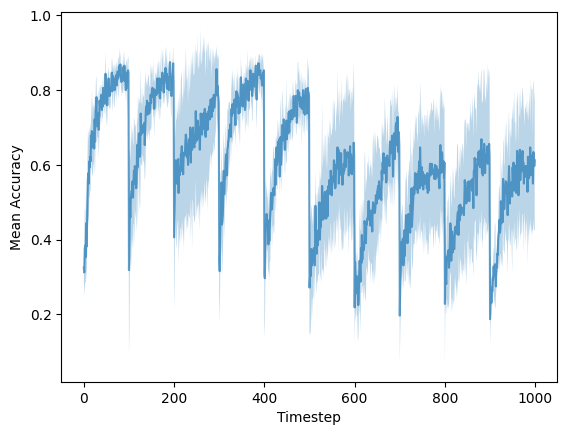

In [31]:
plt.plot(vqc_acc_mean, alpha=0.7)
plt.fill_between(range(all_vqc_acc.shape[1]), vqc_acc_mean - vqc_acc_err, vqc_acc_mean + vqc_acc_err, alpha=0.3)
plt.xlabel("Timestep")
plt.ylabel("Mean Accuracy")

# Training sample with classical ANN

In [34]:
### Classical ANN Parameters
device = "cpu"

task_name = "LabelPermutedEMNIST"
task_params = {
    "dataset_root": "../dataset",      # Change this path depending on where the dataset is allocated
    "in_dim": [16, 16],
    "out_dim": 4,
    "train": True,
    "shuffle": True,
    "update_freq": 100,
    "batch_size": 64,
    "img_transform": T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize([16, 16]),
        T.Normalize((0.5, ), (0.5, )),
        T.Lambda(lambda x: x.flatten()),
    ]),
    "label_subset": [23, 24, 25, 26]
}

model_name = "ClassicalReLUFCNN"
model_params =  {
    "layer_sizes": [256, 300, 150, 4]
}

n_runs = 5
n_timesteps = 1000
step_size = 0.01
seed = 42

In [33]:
seed_everything(seed)
seeds = np.random.randint(0, 1000000000, size=5)

In [35]:
all_cls_acc = []
torch_device = torch.device(device)
for run in tqdm(range(1, n_runs+1)):
    seed_everything(seeds[run-1])

    task = TASKS[task_name](**task_params)
    model = MODELS[model_name](**model_params)
    optimizer = OPTIMS["Adam"](model.parameters(), step_size)
    loss_fn = LOSSES["cross_entropy"]

    cls_acc = np.zeros(n_timesteps)
    
    model = model.to(torch_device)
    model.train()
    for t, (x, y) in enumerate(task):
        x, y = x.to(torch_device), y.to(torch_device)
        pred = model(x)
        
        optimizer.zero_grad()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            p = model(x)
            p = p.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            cls_acc[t] = accuracy(p, y)
            
        if t + 1 >= n_timesteps:
            break

    all_cls_acc.append(cls_acc)

  0%|                                                                                                                                                                                                                                    | 0/5 [00:00<?, ?it/s]/var/folders/4v/js24ky4n0k766ycqysv0qttw0000gn/T/ipykernel_4227/213515281.py:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.23s/it]


In [36]:
# Plot the results
all_cls_acc = np.array(all_cls_acc)
cls_acc_mean = all_cls_acc.mean(axis=0)
cls_acc_err = 1.96 * all_cls_acc.std(axis=0) / np.sqrt(all_cls_acc.shape[0]) # 95% confidence interval

Text(0, 0.5, 'Mean Accuracy')

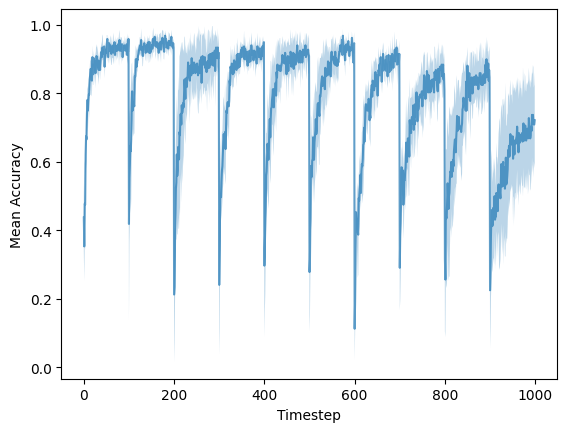

In [37]:
plt.plot(cls_acc_mean, alpha=0.7)
plt.fill_between(range(all_cls_acc.shape[1]), cls_acc_mean - cls_acc_err, cls_acc_mean + cls_acc_err, alpha=0.3)
plt.xlabel("Timestep")
plt.ylabel("Mean Accuracy")